In [76]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ydata_profiling import ProfileReport

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from imblearn.over_sampling import SMOTENC
from sklearn.datasets import make_classification
from collections import Counter

from sklearn.impute import KNNImputer
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, log_loss
from sklearn.feature_selection import SelectKBest, chi2, SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_selection import mutual_info_classif

from xgboost import XGBClassifier
from numpy.random import RandomState

import shap
shap.initjs()


In [41]:
file_path = '../data/data_small.csv'
df = pd.read_csv(file_path, encoding='UTF-8', low_memory=False)
df.shape

(17272, 17)

In [42]:
float_data = [
    'age',
    'BMI',
    'protein_energy_ratio',
    'fat_energy_ratio',
    'carbohydrate_energy_ratio',
    'energy'
]

In [43]:
categorical_data = [
    'sex',
    'heavy_drink',
    'smoke',
    'genetic_diabetes',
    'abdominal_obesity',
    'Hypercholesterolemia',
    'hypertriglyceridemia',
    'high_bloodpressure',
    'stroke',
    'walking_practice'
]

In [44]:
# MinMaxScaler 객체 생성
scaler = MinMaxScaler()

# 선택한 열에 대해 정규화 적합 및 변환
for col in float_data:
    try:
        df[col] = scaler.fit_transform(df[col].values.reshape(-1, 1)).flatten()
    except KeyError:
        pass
df.head()

,sex,age,heavy_drink,smoke,genetic_diabetes,abdominal_obesity,Hypercholesterolemia,hypertriglyceridemia,high_bloodpressure,stroke,BMI,walking_practice,protein_energy_ratio,fat_energy_ratio,carbohydrate_energy_ratio,energy,diabetes
0,1,0.683333,1,0,0,1,0,0,3,0,0.246797,0,0.257002,0.244561,0.663757,0.156614,1
1,1,0.133333,0,0,0,0,0,0,1,0,0.060075,0,0.243481,0.348684,0.592662,0.150485,0
2,1,0.550000,1,1,0,0,0,0,2,0,0.119276,0,0.264621,0.226579,0.672799,0.126264,0
3,2,0.500000,0,0,0,0,0,0,1,0,0.260036,0,0.278310,0.386940,0.542170,0.135401,0
4,2,0.850000,0,0,0,1,0,0,3,0,0.315124,0,0.265598,0.429812,0.517273,0.137300,0


In [45]:
y = df.diabetes
X = df.drop('diabetes', axis=1)

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

In [47]:
# SMOTE-NC를 적용할 훈련 데이터에 대한 범주형 열의 인덱스 생성
categorical_indices = [X_train.columns.get_loc(col) for col in categorical_data]

# SMOTE-NC 적용
smote_nc = SMOTENC(categorical_features=categorical_indices, random_state=0)
X_train_resampled, y_train_resampled = smote_nc.fit_resample(X_train, y_train)

# 결과 확인
print("Original training data shape:", X_train.shape, y_train.shape)
print("Resampled training data shape:", X_train_resampled.shape, y_train_resampled.shape)
print("Test data shape:", X_test.shape, y_test.shape)

Original training data shape: (13817, 16) (13817,)
Resampled training data shape: (23040, 16) (23040,)
Test data shape: (3455, 16) (3455,)


In [48]:
X_train = X_train_resampled
y_train = y_train_resampled
# XGBModel = XGBClassifier(tree_method='gpu_hist', gpu_id=0, enable_categorical=True)
XGBModel = XGBClassifier(device='cuda', enable_categorical=True)
XGBModel.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='cuda', early_stopping_rounds=None,
              enable_categorical=True, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

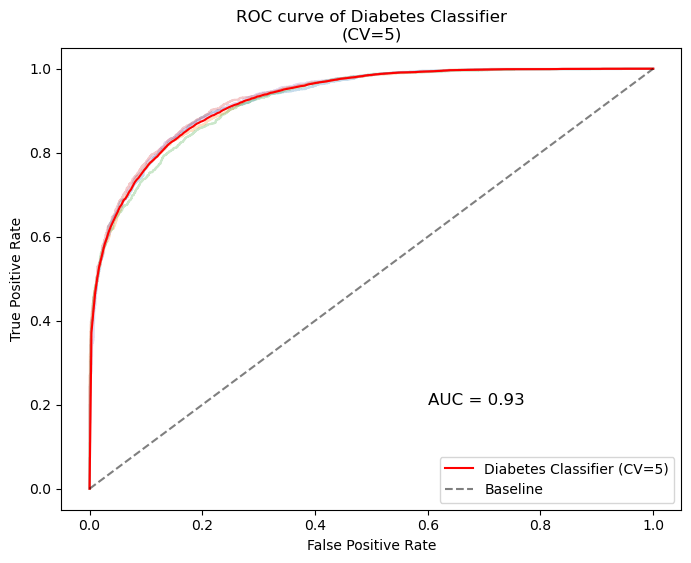

Fold 1 - AUC: 0.93, Accuracy: 0.84, F1 Score: 0.85
Fold 2 - AUC: 0.93, Accuracy: 0.83, F1 Score: 0.83
Fold 3 - AUC: 0.92, Accuracy: 0.83, F1 Score: 0.84
Fold 4 - AUC: 0.93, Accuracy: 0.85, F1 Score: 0.85
Fold 5 - AUC: 0.93, Accuracy: 0.84, F1 Score: 0.85
Mean AUC: 0.93
Mean Accuracy: 0.84
Mean F1 Score: 0.84


In [80]:
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score

kf = KFold(n_splits=5, shuffle=True, random_state=42)
tprs_diabetes = []
base_fpr_diabetes = np.linspace(0, 1, 300)

# 각 fold에서의 AUC, 정확도, F1 점수를 저장할 리스트
auc_scores = []
accuracy_scores = []
f1_scores = []

# 기존 코드와 같이 ROC 곡선을 그리는 부분
plt.figure(figsize=(8, 6))
base_fpr = np.linspace(0, 1, 300)

for train_idx, val_idx in kf.split(X_train):
    X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    XGBModel.fit(X_train_fold, y_train_fold)
    
    y_val_prob_fold = XGBModel.predict_proba(X_val_fold)[:, 1]
    y_val_pred_fold = XGBModel.predict(X_val_fold)
    
    FPR_fold, TPR_fold, _ = roc_curve(y_val_fold, y_val_prob_fold)
    
    plt.plot(FPR_fold, TPR_fold, alpha=0.25)
    tpr_fold = np.interp(base_fpr_diabetes, FPR_fold, TPR_fold)
    tpr_fold[0] = 0.0
    tprs_diabetes.append(tpr_fold)
    
    # 평가 지표 계산
    auc_score_fold = roc_auc_score(y_val_fold, y_val_prob_fold)
    accuracy_score_fold = accuracy_score(y_val_fold, y_val_pred_fold)
    f1_score_fold = f1_score(y_val_fold, y_val_pred_fold)
    
    # 평가 지표 저장
    auc_scores.append(auc_score_fold)
    accuracy_scores.append(accuracy_score_fold)
    f1_scores.append(f1_score_fold)

# 최종 ROC 곡선 그리기
tprs_diabetes = np.array(tprs_diabetes)
mean_tprs_diabetes = np.mean(tprs_diabetes, axis=0)
mean_tprs_diabetes[-1] = 1.0
mean_auc = np.mean(auc_scores)

plt.plot(base_fpr, mean_tprs_diabetes, label='Diabetes Classifier (CV=5)', color='red')
plt.plot([0, 1], [0, 1], label='Baseline', color='black', linestyle='--', alpha=0.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve of Diabetes Classifier\n(CV=5)')
plt.legend(loc='lower right')
plt.text(0.6, 0.2, f'AUC = {mean_auc:.2f}', fontsize=12)
plt.show()

# 각 fold의 평가 지표 출력
for i, (auc, acc, f1) in enumerate(zip(auc_scores, accuracy_scores, f1_scores)):
    print(f'Fold {i+1} - AUC: {auc:.2f}, Accuracy: {acc:.2f}, F1 Score: {f1:.2f}')

# 최종 평균 평가 지표 출력
print(f'Mean AUC: {np.mean(auc_scores):.2f}')
print(f'Mean Accuracy: {np.mean(accuracy_scores):.2f}')
print(f'Mean F1 Score: {np.mean(f1_scores):.2f}')


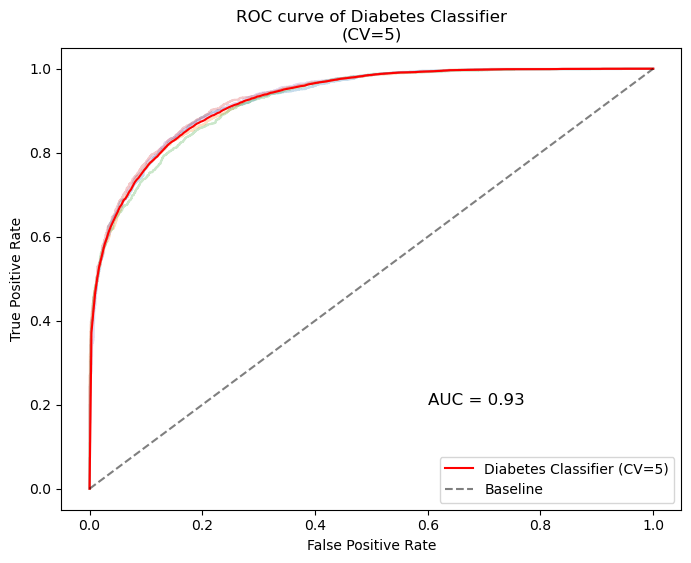

Fold 1 - AUC: 0.93, Accuracy: 0.84, F1 Score: 0.85
Fold 2 - AUC: 0.93, Accuracy: 0.83, F1 Score: 0.83
Fold 3 - AUC: 0.92, Accuracy: 0.83, F1 Score: 0.84
Fold 4 - AUC: 0.93, Accuracy: 0.85, F1 Score: 0.85
Fold 5 - AUC: 0.93, Accuracy: 0.84, F1 Score: 0.85
Mean AUC: 0.93
Mean Accuracy: 0.84
Mean F1 Score: 0.84


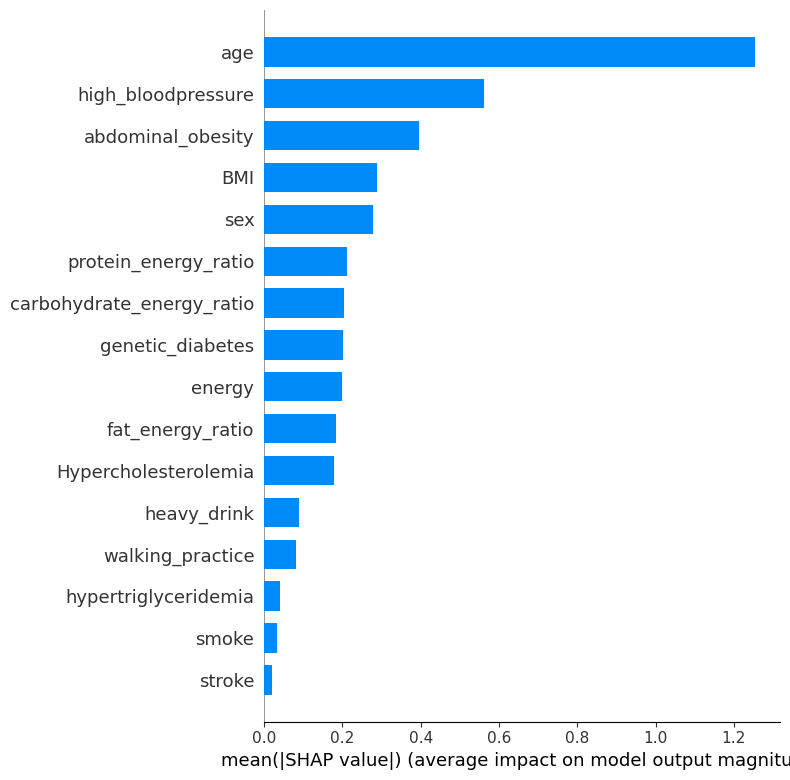

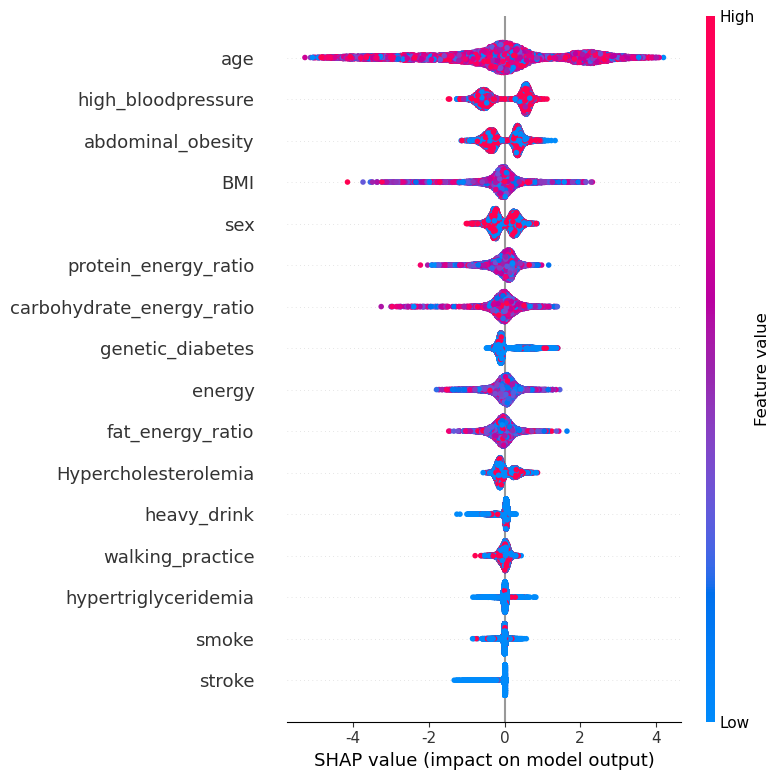

In [83]:
import shap

kf = KFold(n_splits=5, shuffle=True, random_state=42)
tprs_diabetes = []
base_fpr_diabetes = np.linspace(0, 1, 300)

# 각 fold에서의 AUC, 정확도, F1 점수를 저장할 리스트
auc_scores = []
accuracy_scores = []
f1_scores = []

# SHAP 값을 저장할 리스트
shap_values_list = []
expected_values_list = []

# 기존 코드와 같이 ROC 곡선을 그리는 부분
plt.figure(figsize=(8, 6))
base_fpr = np.linspace(0, 1, 300)

for train_idx, val_idx in kf.split(X_train):
    X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    XGBModel.fit(X_train_fold, y_train_fold)
    
    y_val_prob_fold = XGBModel.predict_proba(X_val_fold)[:, 1]
    y_val_pred_fold = XGBModel.predict(X_val_fold)
    
    FPR_fold, TPR_fold, _ = roc_curve(y_val_fold, y_val_prob_fold)
    
    plt.plot(FPR_fold, TPR_fold, alpha=0.25)
    tpr_fold = np.interp(base_fpr_diabetes, FPR_fold, TPR_fold)
    tpr_fold[0] = 0.0
    tprs_diabetes.append(tpr_fold)
    
    # 평가 지표 계산
    auc_score_fold = roc_auc_score(y_val_fold, y_val_prob_fold)
    accuracy_score_fold = accuracy_score(y_val_fold, y_val_pred_fold)
    f1_score_fold = f1_score(y_val_fold, y_val_pred_fold)
    
    # 평가 지표 저장
    auc_scores.append(auc_score_fold)
    accuracy_scores.append(accuracy_score_fold)
    f1_scores.append(f1_score_fold)

    # SHAP 값 계산
    explainer = shap.TreeExplainer(XGBModel)
    shap_values = explainer.shap_values(X_val_fold)
    shap_values_list.append(shap_values)
    expected_values_list.append(explainer.expected_value)

# 최종 ROC 곡선 그리기
tprs_diabetes = np.array(tprs_diabetes)
mean_tprs_diabetes = np.mean(tprs_diabetes, axis=0)
mean_tprs_diabetes[-1] = 1.0
mean_auc = np.mean(auc_scores)

plt.plot(base_fpr, mean_tprs_diabetes, label='Diabetes Classifier (CV=5)', color='red')
plt.plot([0, 1], [0, 1], label='Baseline', color='black', linestyle='--', alpha=0.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve of Diabetes Classifier\n(CV=5)')
plt.legend(loc='lower right')
plt.text(0.6, 0.2, f'AUC = {mean_auc:.2f}', fontsize=12)
plt.show()

# 각 fold의 평가 지표 출력
for i, (auc, acc, f1) in enumerate(zip(auc_scores, accuracy_scores, f1_scores)):
    print(f'Fold {i+1} - AUC: {auc:.2f}, Accuracy: {acc:.2f}, F1 Score: {f1:.2f}')

# 최종 평균 평가 지표 출력
print(f'Mean AUC: {np.mean(auc_scores):.2f}')
print(f'Mean Accuracy: {np.mean(accuracy_scores):.2f}')
print(f'Mean F1 Score: {np.mean(f1_scores):.2f}')

# SHAP 값 시각화
# SHAP 값 결합 (리스트를 평탄화)
combined_shap_values = np.concatenate(shap_values_list, axis=0)
combined_expected_values = np.mean(expected_values_list)

# 전체 데이터에 대한 SHAP 값 시각화
shap.summary_plot(combined_shap_values, X_train, plot_type="bar")
shap.summary_plot(combined_shap_values, X_train)


In [81]:
XGBModel.score(X_test, y_test)

0.7615050651230101

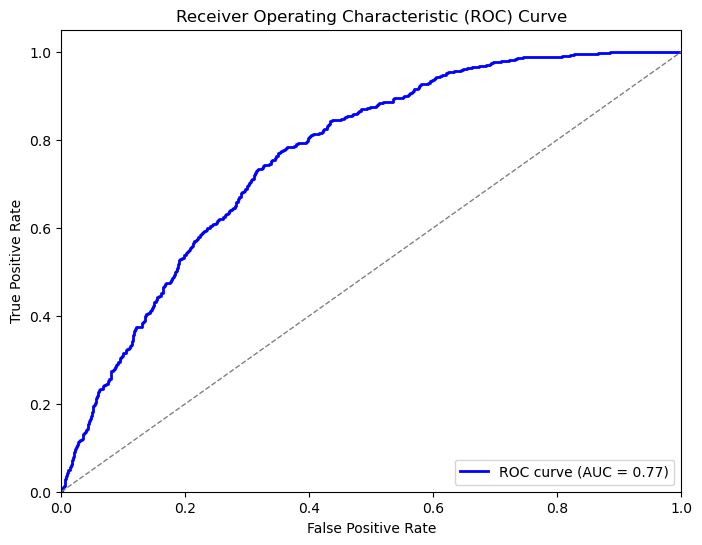

In [50]:
# Calculate ROC curve
y_prob = XGBModel.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Calculate AUC
auc = roc_auc_score(y_test, y_prob)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = {:.2f})'.format(auc))
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [51]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix

# 모델 예측
y_pred = XGBModel.predict(X_test)

# 정확도 계산
accuracy = accuracy_score(y_test, y_pred)
print("정확도:", accuracy)

# 정밀도 계산
precision = precision_score(y_test, y_pred)
print("정밀도:", precision)

# 재현율 계산
recall = recall_score(y_test, y_pred)
print("재현율:", recall)

# F1 점수 계산
f1 = f1_score(y_test, y_pred)
print("F1 점수:", f1)

# AUC 계산
auc = roc_auc_score(y_test, y_pred)
print("AUC:", auc)

# 혼동 행렬 출력
conf_matrix = confusion_matrix(y_test, y_pred)
print("혼동 행렬:")
print(conf_matrix)

정확도: 0.7649782923299566
정밀도: 0.3329268292682927
재현율: 0.5074349442379182
F1 점수: 0.4020618556701031
AUC: 0.6599567590575948
혼동 행렬:
[[2370  547]
 [ 265  273]]


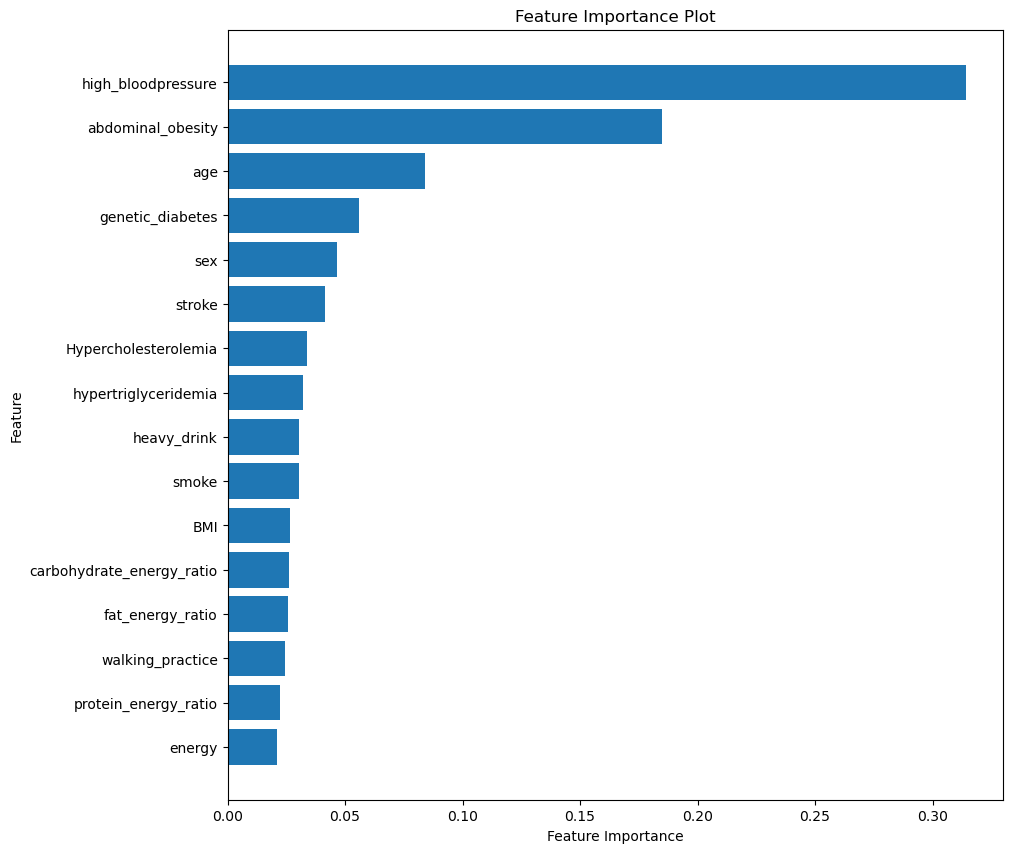

In [52]:
# Assuming you have a model that provides feature importances (e.g., XGBoost)
importances = XGBModel.feature_importances_

# Create a DataFrame to store feature importances
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})

# Sort the DataFrame by feature importances in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=True)

# Plot feature importances
plt.figure(figsize=(10, 10))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance Plot')
plt.show()

In [53]:
shap_values = shap.TreeExplainer(XGBModel).shap_values(X_test)
shap_interaction_values = shap.TreeExplainer(XGBModel).shap_interaction_values(
    X_test
)

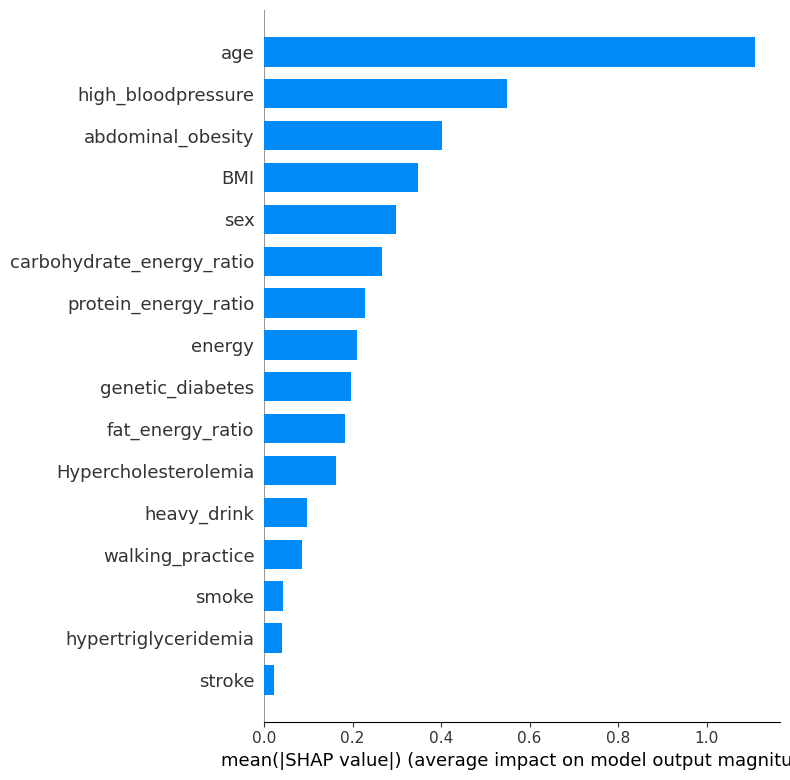

In [54]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

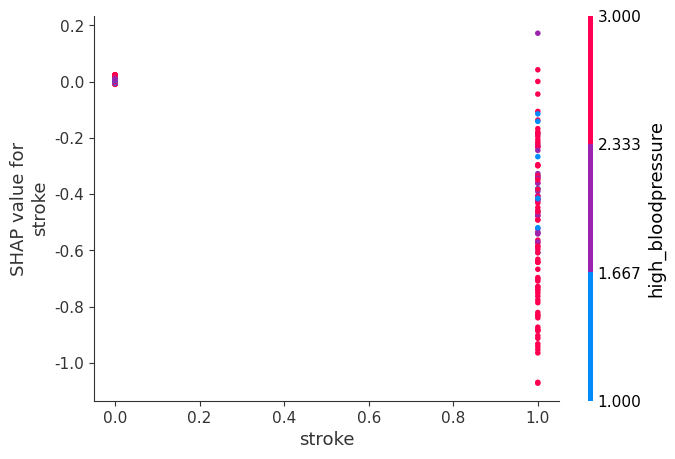

In [55]:
shap.dependence_plot('stroke', shap_values, X_test)

In [56]:
shap.force_plot(shap.TreeExplainer(XGBModel).expected_value, shap_values[0,:], X_test.iloc[0,:])

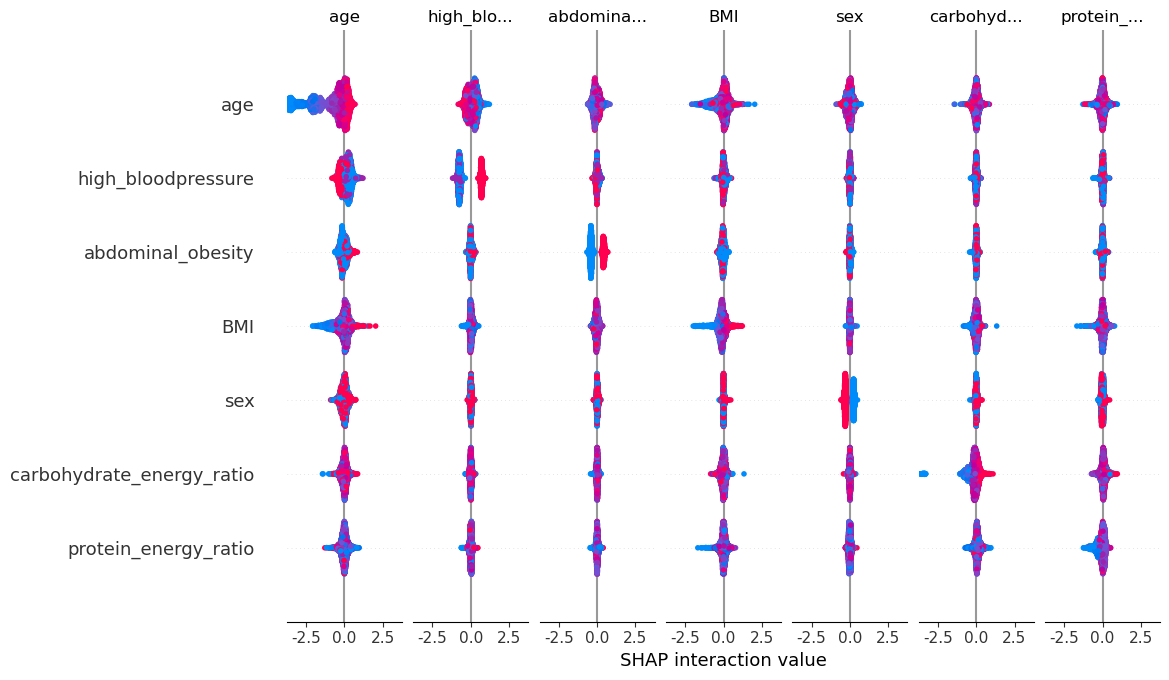

In [57]:
shap.summary_plot(shap_interaction_values, X_test)

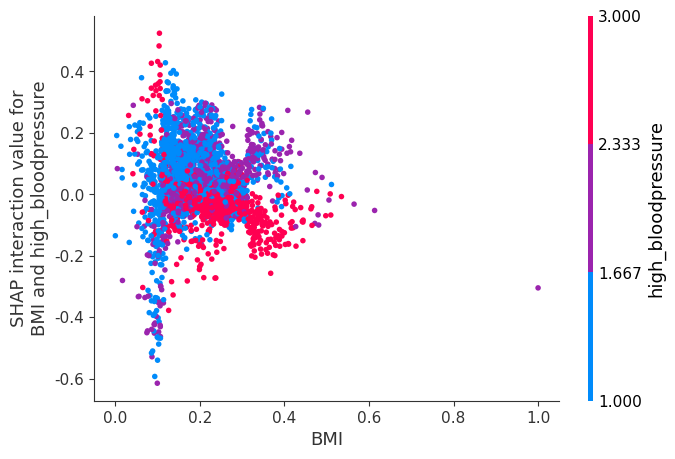

In [64]:
shap.dependence_plot(('BMI', 'high_bloodpressure'), shap_interaction_values, X_test)

In [59]:
# SHAP 값을 계산합니다.
explainer = shap.Explainer(XGBModel, X_train)
shap_values = explainer(X_test)

def waterfall_plot_idx(i):
    # 특정 예측에 대한 waterfall plot을 그립니다.
    index = i  # 원하는 예측의 인덱스를 선택합니다.
    shap.waterfall_plot(shap_values[index], max_display=20, show=False)
    plt.show()

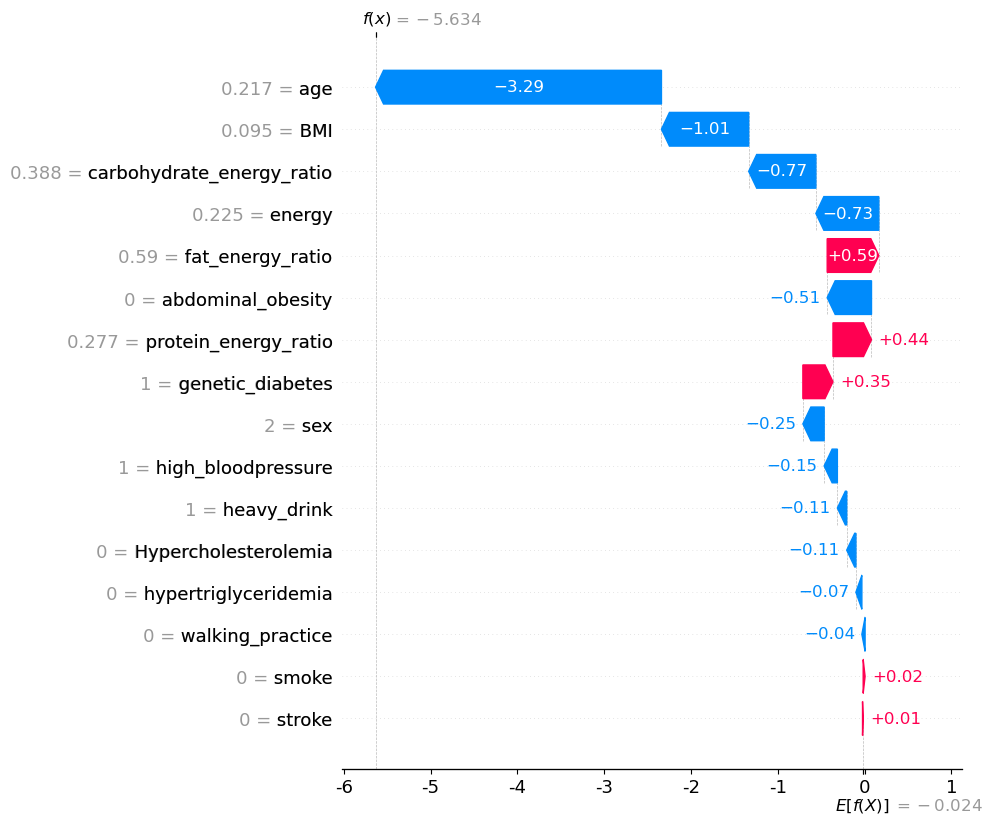

In [60]:
waterfall_plot_idx(1)

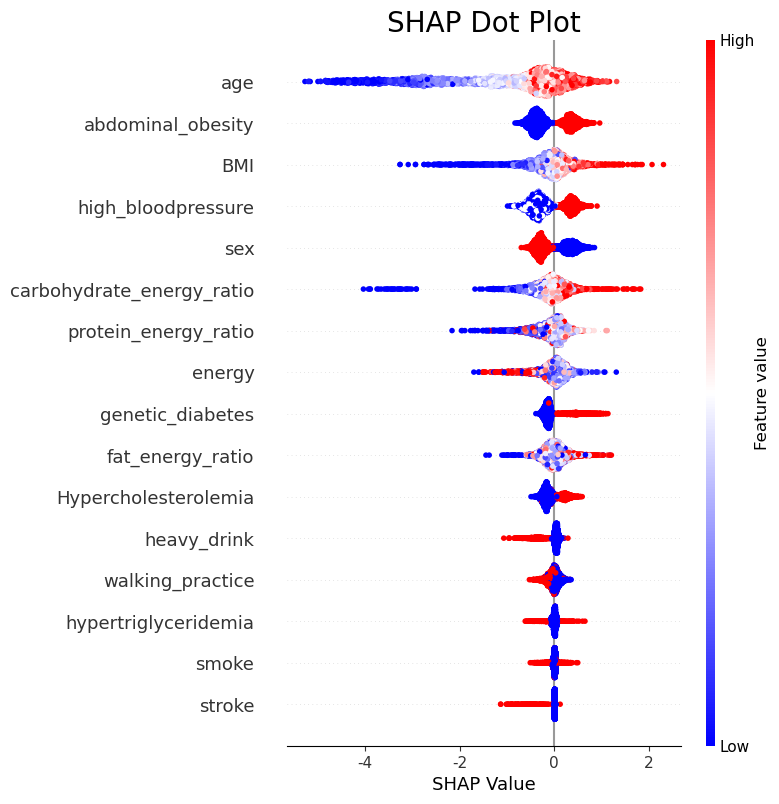

In [61]:
## Dot Plot
plt.rcParams['axes.unicode_minus'] = False

fig = plt.figure(figsize=(8,8))
fig.set_facecolor('white')
ax = fig.add_subplot()
shap.summary_plot(shap_values, X_test, 
                  cmap='bwr', ## 컬러맵
                  show=False, ## 기존 X축 라벨 표시 안함
                 )
ax.set_xlabel('SHAP Value')
ax.set_title('SHAP Dot Plot', fontsize=20)
plt.show()